In [2]:
from data import HomDensityDataset
import matplotlib.pyplot as plt
data = HomDensityDataset(
    root="/export/canton/data/yma93/anydim_transferability/GNN_size_generalizability",
    N=500,
    n=50,
    graph_model="full_SBM_Gaussian",
    task="triangle",
)

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


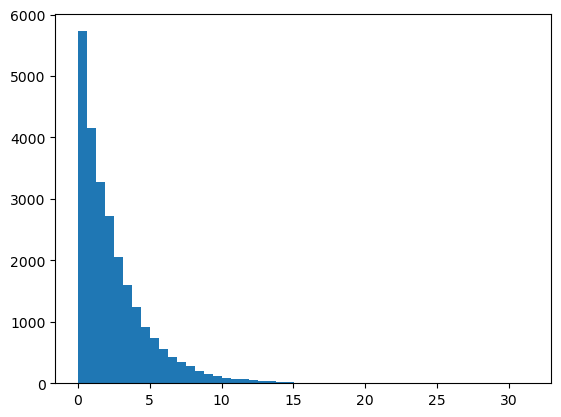

In [8]:
plt.hist(data.y, bins=50)
plt.show()

In [ ]:
from torch_geometric.utils import to_dense_adj
A=to_dense_adj(data[0].edge_index).squeeze()
A.sum(dim=0)

In [ ]:
from ign_layers import layer_2_to_2_anydim, layer_2_to_1_anydim
import torch
gnn = layer_2_to_2_anydim(input_depth=1, output_depth=3)
gnn.all_bias = torch.nn.Parameter(torch.ones(1,3,1,1))
A = torch.randn(5, 3, 30, 30) * 50
A2 = torch.kron(A, torch.ones(1,1,5,5))
A = gnn(gnn(A))
A2 = gnn(gnn(A2))
print(
    torch.max(
        torch.abs(
            torch.kron(A, torch.ones(1, 1, 5, 5)) - A2,
        )
    )
)

In [ ]:
A = torch.randn(5, 3, 30, 30) * 50
A2 = torch.kron(A, torch.ones(1,1,5,5))
gnn = layer_2_to_1_anydim(input_depth=3, output_depth=3)
X = gnn(A)
X2 = gnn(A2)
print(
    torch.max(
        torch.abs(
            torch.kron(X, torch.ones(1, 1, 5)) - X2,
        )
    )
)   

In [ ]:
# check whether model is compatible
from model import GNN_layer
import torch

reduced = True
gnn1 = GNN_layer(A_in_channels=1, A_out_channels=3, x_in_channels=3, x_out_channels=3, reduced=reduced)
# gnn1.A_bias = torch.nn.Parameter(torch.ones(1,1,1,3))
# gnn1.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))
# gnn1.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))
gnn2 = GNN_layer(A_in_channels=3, A_out_channels=3, x_in_channels=3, x_out_channels=3, reduced=reduced)
# gnn2.A_bias = torch.nn.Parameter(torch.ones(1, 1, 1, 3))
# gnn2.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))
# gnn2.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))

A = torch.randn(5, 1, 30, 30) * 5
X = torch.randn(5, 30, 3) * 50
A2 = torch.kron(A, torch.ones(1, 1, 10, 10))
X2 = torch.kron(X, torch.ones(1, 10, 1))

A, X = gnn1(A, X)
A, X = gnn2(A, X)
A = A.contiguous()
X = X.contiguous()

A2, X2 = gnn1(A2, X2)
A2, X2 = gnn2(A2, X2)
A2 = A2.contiguous()
X2 = X2.contiguous()

In [ ]:
print(torch.max(torch.abs(torch.kron(A, torch.ones(1, 1, 10, 10))- A2,)))

In [ ]:
print(torch.max(torch.abs((torch.kron(X, torch.ones(1, 10, 1)) - X2)/X2)))

In [ ]:
torch.allclose(torch.kron(A, torch.ones(1, 1, 10, 10)), A2, atol=1e-2)

In [ ]:
torch.allclose(torch.kron(X, torch.ones(1, 10, 1)), X2, rtol=1e-2)

In [ ]:
X[0, :, 0]

In [ ]:
X2[0,:,0]

In [ ]:
import os,json
import numpy as np
import matplotlib.pyplot as plt
num_trials = 10
log_test_n_range = np.arange(1.7, 3.4, 0.4)
test_n_range = np.array([int(10**i) for i in log_test_n_range])
for model in ["simple","ign_anydim", "reduced", "unreduced"]:
    fname = f"results_Sociality_conditional_triangle_{model}.json"
    current_directory = os.getcwd()
    with open(os.path.join("log/size_generalizability", fname), "r") as f:
        results = json.load(f)
    mse_list = [results[model][str(seed)] for seed in range(num_trials)]
    mean_mse = np.median(mse_list, axis=0)
    std_mse = np.std(mse_list, axis=0)

    x = np.array(test_n_range)
    plt.plot(x, mean_mse, label = model)
    # plt.fill_between(
    #     x,
    #     mean_mse - std_mse,
    #     mean_mse + std_mse,
    #     alpha=0.3,
    # )
plt.xscale("log")
plt.xlabel("Test set size (N)")
plt.ylabel("Mean relative error")
plt.legend()

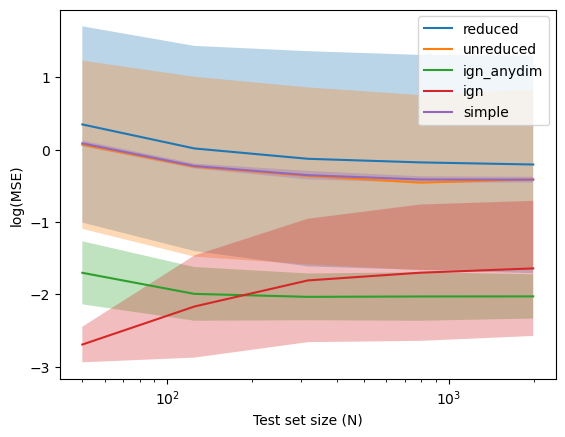

In [7]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

num_trials = 10
log_test_n_range = np.arange(1.7, 3.4, 0.4)
test_n_range = np.array([int(10**i) for i in log_test_n_range])
for model in ["reduced", "unreduced", "ign_anydim", "ign", "simple"]:
    fname = f"results_full_SBM_Gaussian_triangle_{model}.json"
    current_directory = os.getcwd()
    with open(os.path.join("log/size_generalizability", fname), "r") as f:
        results = json.load(f)
    mse_list = [results[model][str(seed)] for seed in range(num_trials)]
    mean_mse = np.mean(np.log(mse_list), axis=0)
    std_mse = np.std(np.log(mse_list), axis=0)
    x = np.array(test_n_range)
    plt.plot(x, mean_mse, label=model)
    plt.fill_between(
        x,
        mean_mse - std_mse,
        mean_mse + std_mse,
        alpha=0.3,
    )
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Test set size (N)")
plt.ylabel("log(MSE)")
plt.legend()

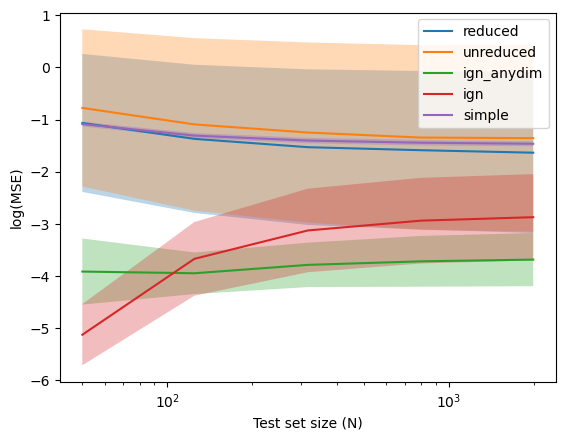

In [8]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

num_trials = 10
log_test_n_range = np.arange(1.7, 3.4, 0.4)
test_n_range = np.array([int(10**i) for i in log_test_n_range])
for model in ["reduced", "unreduced", "ign_anydim", "ign", "simple"]:
    fname = f"results_full_SBM_Gaussian_degree_{model}.json"
    current_directory = os.getcwd()
    with open(os.path.join("log/size_generalizability", fname), "r") as f:
        results = json.load(f)
    mse_list = [results[model][str(seed)] for seed in range(num_trials)]
    mean_mse = np.mean(np.log(mse_list), axis=0)
    std_mse = np.std(np.log(mse_list), axis=0)
    x = np.array(test_n_range)
    plt.plot(x, mean_mse, label=model)
    plt.fill_between(
        x,
        mean_mse - std_mse,
        mean_mse + std_mse,
        alpha=0.3,
    )
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Test set size (N)")
plt.ylabel("log(MSE)")
plt.legend()

# study trained unreduced model

In [ ]:
import torch
state_dict = torch.load("log/transferability/anydim_transferability/el33aj98/checkpoints/epoch=494-step=11385-val_loss=0.00.ckpt")["state_dict"]

In [ ]:
state_dict.keys()

In [ ]:
state_dict["model.layers.0.A_l5.weight"]

In [ ]:
for key in state_dict.keys():
    if 'A_l3' in key or 'A_l5' in key:
        print(key)
        print(state_dict[key])

In [ ]:
for key in state_dict.keys():
    if "X1_l4" in key or "X1_l5" in key:
        print(key)
        print(state_dict[key])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def W(x, y):
    return 1-np.exp(-2 * x * y)
    # return np.exp(-((x - y) ** 2)/0.1)


# Create a grid of x and y values
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Compute W(x, y) for each pair of x and y values
Z = W(X, Y)
print(Z.max(), Z.min())
# Plot the resulting matrix
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap="viridis")
plt.colorbar(label="W(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Graph of W(x, y) = exp(-(x-y)^2)")
plt.show()

In [ ]:
import torch

# Create a random tensor
tensor = torch.tensor([[3, 1, 4], 
                       [1, 5, 9], 
                       [2, 6, 5]])

# Sort the tensor along dimension 0 (rows)
sorted_tensor_dim0, indices_dim0 = torch.sort(tensor, dim=0)

# Sort the tensor along dimension 1 (columns)
sorted_tensor_dim1, indices_dim1 = torch.sort(tensor, dim=1)

In [ ]:
sorted_tensor_dim0